# INF8111 - Fouille de donn√©es


## TP1 √ât√© 2024 - Duplicate Bug Report Detection

##### Date de remise: 19/05 √† 23:55

##### La note TP sera p√©nalis√©e de 10 points si le notebook met plus d'1h √† s'ex√©cuter. 



#### Membres de l'√©quipe:

    - Nicolas Depelteau (2083544)
    
##### Deliverables:

Vous devez soumettre deux fichiers distincts sur Moodle: 
1. Ce notebook
2. Un [Json](https://en.wikipedia.org/wiki/JSON) contenant du contenu de page Web r√©cup√©r√© (bug_reports.json) 
    


## R√©sum√©

En raison de la complexit√© des syst√®mes logiciels, les bogues logiciels sont r√©pandus. Les entreprises, en particulier les grandes, utilisent g√©n√©ralement un syst√®me de suivi des bogues (BTS), √©galement appel√© syst√®me de suivi des probl√®mes, pour g√©rer et suivre les enregistrements des bogues. Outre les d√©veloppeurs et les testeurs, de nombreux projets, principalement des projets open source, permettent aux utilisateurs de signaler de nouveaux bogues dans leur BTS. Pour ce faire, les utilisateurs doivent remplir un formulaire avec plusieurs champs. Un sous-ensemble important de ces champs fournissent des donn√©es cat√©gorielles et n'acceptent que les valeurs d'une liste fixe d‚Äôoptions (par exemple, composant, version et produit du syst√®me). Deux autres domaines importants sont le r√©sum√© et la description. Les utilisateurs sont libres d'√©crire ce qu'ils veulent dans ces deux champs avec la seule contrainte que le r√©sum√© ne d√©passe pas un nombre maximal de caract√®res. La soumission d'un formulaire cr√©e une page, appel√©e rapport de bogue ou rapport de probl√®me, qui contient toutes les informations sur un bogue.

En raison du manque de communication et de synchronisation, les utilisateurs peuvent ne pas savoir qu'un bogue sp√©cifique a d√©j√† √©t√© soumis et le signalent √† nouveau. Identifier les rapports de bogues en double est une t√¢che importante dans les BTS et c'est le sujet de ce TP. Fondamentalement, notre objectif est de d√©velopper un syst√®me qui pr√©dit si une paire de nouveau rapport de bogue et un rapport de bogue soumis sont dupliqu√© ou non. Ce syst√®me sera utilis√© pour identifier manuellement les rapports dupliqu√©.

# 2 Pr√©requis

Pour ce TP, vous aurez besoin des librairies `numpy` et `sklearn`, ainsi que la librairie `nltk`, qui est une libraire utilis√©e pour faire du traitement du language (Natural Language Processing, NLP)

Installez les libraires en question et ex√©cutez le code ci-dessous :

In [ ]:
# If you want, you can use anaconda and install after nltk library
!pip install --user numpy
!pip install --user scikit-learn
!pip install --user nltk
!pip install --user bs4

#python
import nltk
nltk.download("punkt")
from IPython import display
display.clear_output()

# 3 - Les donn√©es

T√©l√©chargez l'archive √† l'adresse suivante: https://www.dropbox.com/s/s53fqz29z8ch4ip/data.zip?dl=0

L'archive contient: 

1. training.txt : ce fichier contient des paires de rapports de bogues qui seront utilis√©s pour entra√Æner notre syst√®me.
2. validation.txt : Ce fichier contient des paires de rapports de bogues qui seront utilis√©s pour √©valuer notre syst√®me.
2. bug_reports : Ce dossier contient le code HTML des rapports de bogues. Chaque fichier HTML est nomm√© selon le motif **bug_report_id.html**.


L'image ci-dessous illustre un exemple de bug report:



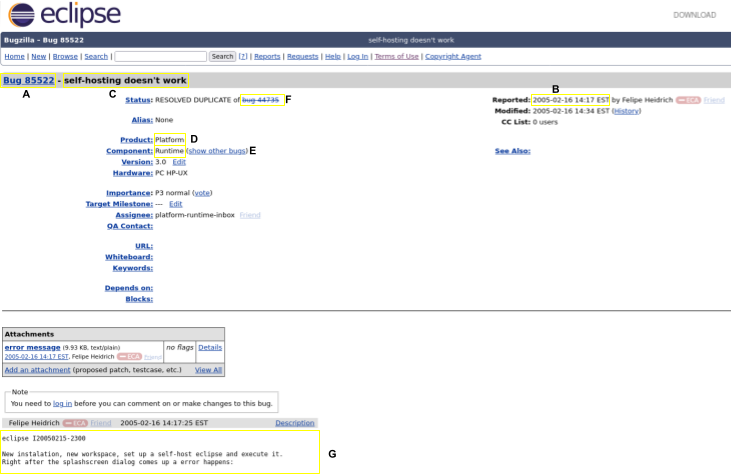

In [2]:
from IPython import display
!rm -rf data.zip data
!gdown 12z5OddTOEn7hnQFaHh9qwrbVJTnqtDq-
!unzip data.zip
!rm -rf data.zip
display.clear_output()
display.Image("https://irving-muller.github.io/images/bug-report-eclipse.png")

- A : identifiant du bug report
- B : date de cr√©ation
- C : r√©sum√©
- D : produit
- E : composant
- F : l'identifiant du rapport dont le bug report est dupliqu√©
- G : description


Le script suivant charge le jeu de donn√©es de test et d√©finit certaines variables globales:

In [3]:
import os

# d√©finir le chemin du dossier qui contient les donn√©es 
FOLDER_PATH = "data/"
PAGE_FOLDER = os.path.join(FOLDER_PATH, 'bug_reports')


# Charger l'ensemble de donn√©es d'√©valuation 
import json


training_file = open(os.path.join(FOLDER_PATH, "training.txt"))
validation_file = open(os.path.join(FOLDER_PATH, "validation.txt"))
word_vec_path = os.path.join(FOLDER_PATH, "glove.42B.300d_clear.txt")

def read_dataset(f):
    for line in f:
        line = line.strip()
        
        if len(line) == 0:
            continue
        
        rep1, rep2, label = line.split(',')

        rep1 = int(rep1)
        rep2 = int(rep2)
        label = 1.0 if int(label) > 0 else 0.0 
        
        yield (rep1, rep2, label)
    
    


training_pairs = list(read_dataset(training_file))
validation_pairs = list(read_dataset(validation_file))

training_reports_set = set()


for r1, r2, _ in training_pairs:
    training_reports_set.add(r1)
    training_reports_set.add(r2)

# 4 - Web scraping

"Le *web scraping* (parfois appel√© harvesting) est une technique d'extraction du contenu de sites Web, via un script ou un programme, dans le but de le transformer pour permettre son utilisation dans un autre contexte, par exemple le r√©f√©rencement." [Wikipedia](https://fr.wikipedia.org/wiki/Web_scraping)


## 4.1 - Question 1 (4 points)

Impl√©mentez la fonction *extract_data_from_page* qui extrait les informations suivantes du code HTML: l'ID du bug report, la date de cr√©ation, le titre, le produit, le composant, l'ID du bug report dont il est un duplicata, et la description.

La fonction *extract_data_from_page* retourne un dictionnaire avec la structure suivante:

```python
 {"report_id": int, 
  "dup_id": int or None (the report id which it is duplicate), 
  "component": string, 
  "product": string, 
  "summary": string, 
  "description": string, 
  "creation_date": string} 
```

Par exemple, pour le bug report "bug_report/18431.html", la fonction *extract_data_from_page* retourne:
 
```python
{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT'}
```

**La date de cr√©ation doit √™tre repr√©sent√©e sous la forme d'un "ann√©e-mois-jour heure:minute fuseau horaire". Si un bug report n'est pas un duplicata, alors dup_id doit √™tre None.**

*Indice: lxml parse est plus rapide que html.parser*

In [9]:
from bs4 import BeautifulSoup
import re

def extract_data_from_page(pagepath, page_html=None):
    """
    Scrap le contenu du rapport de html 
    
    :param pagepath: le chemin du fichier html. 
    :return: 
        {
        "report_id": int,
        "dup_id": int or None (l'identifiant du rapport dont il est dupliqu√©), 
        "component": string, 
        "product": string, 
        "summary": string, 
        "description": string, 
        "creation_date": string
        }
    """
    
    if page_html is None:
        with open(pagepath, 'r') as f:
            page_html = f.read()
            
    soup = None
    report_id = None
    dup_id = None
    component = None
    product = None
    summary = None
    description = None
    creation_date = None
    
    soup = BeautifulSoup(page_html, 'lxml')

    report = soup.find("div", class_="bz_short_desc_container")
    if report is not None:
        link = report.find("a")
        if link is not None:
            report_id = re.search(r"\d+", link.get_text(strip=True))
            if report_id is not None:
                report_id = report_id.group()
    
    dup = soup.find(id="static_bug_status")
    if dup is not None:
        dup_id = re.search(r"(\d+)", dup.getText())
        if dup_id is not None:
            dup_id = dup_id.group()
    
    component = soup.find(id="field_container_component")
    if component is not None:
        component = component.getText().strip()
        if component is not None:
            component = re.search(r"^([\w\s-]+)", component)
            if component is not None:
                component = component.group().strip()

    product = soup.find(id="field_container_product")
    if product is not None:
        product = product.getText().strip()
    
    summary = soup.find(id="short_desc_nonedit_display")
    if summary is not None:
        summary = summary.getText(strip=True)
    
    description = soup.find(class_="bz_comment_text")
    if description is not None:
        description = description.getText(strip=True)

    creation_date = soup.find(id="bz_show_bug_column_2")
    if creation_date is not None:
        creation_date = creation_date.find('th', string=re.compile(r'Reported:', re.IGNORECASE))
        if creation_date is not None:
            creation_date = creation_date.find_next_sibling('td')
            if creation_date is not None:
                creation_date = re.search(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}) (\w+)', creation_date.get_text(strip=True))
                if creation_date is not None:
                    creation_date = creation_date.group()
    
    return {
        "report_id": report_id,
        "dup_id": dup_id,
        "component": component,
        "product": product,
        "summary": summary,
        "description": description,
        "creation_date": creation_date
    }

exemple_report = extract_data_from_page("data/bug_reports/18431.html")
exemple_report

{'report_id': '18431',
 'dup_id': '27227',
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polylin

## 4.3 - Extraction du texte depuis le HTML


In [ ]:
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from time import time
import json
from tqdm.autonotebook import tqdm
import typing as tp

# Indexer chaque rapport par son identifiant 
index_path = os.path.join(FOLDER_PATH, 'bug_reports.json')

if os.path.isfile(index_path):
    report_index = json.load(open(index_path))
else:
    # Extraire le contenu d'une page Web 
    
    # Cela peut √™tre lent (environ 15 minutes). Testez votre code avec un petit √©chantillon. l'analyse lxml est plus rapide que html.parser
    files = [os.path.join(PAGE_FOLDER, filename) for filename in os.listdir(PAGE_FOLDER)]
    reports = [extract_data_from_page(f) for f in tqdm(files)]
    report_index = dict(((report['report_id'], report) for report in reports ))

    # Save preprocessed bug reports
    json.dump(report_index, open(index_path,'w'))


# 5 - Pr√©traitement des donn√©es

Le pr√©traitement des donn√©es est une tache cruciale en fouille de donn√©es. Cette √©tape nettoie et transforme les donn√©es brutes dans un format qui permet leur analyse, et leur utilisation avec des algorithmes de *machine learning*. En traitement des langages (natural language processing, NLP), la *tokenization* et le *stemming* sont des √©tapes cruciales. De plus, vous impl√©menterez une √©tape suppl√©mentaire pour filtrer les mots sans importance.

## 5.1 - Tokenization

Cette √©tape permet de s√©parer un texte en s√©quence de *tokens* (= jetons, ici des mots, symboles ou ponctuation).

Par exemple, la phrase "It's the student's notebook." peut √™tre s√©par√© en liste de tokens de cette mani√®re: ["it", " 's", "the", "student", " 's", "notebook", "."].


### 5.1.1 - Question 2 (1 point) 

**Implementez** ```tokenize_space_punk``` **qui remplace la ponctuation par un espace, puis tokenise les jetons s√©par√©s par des espaces (espace, tabulation, nouvelle ligne). Tous les tokenizers doivent mettre les jetons en minuscule.***

In [11]:
import re
import typing as tp

def tokenize_space_punk(text:str) -> tp.List[str]:
    """
    This tokenizer replaces punctuation to spaces and then tokenizes the tokens that are separated by whitespace (space, tab, newline).
    """
    text = re.sub(r'[^\w\s]', ' ', text)
    tokens = re.split(r'\s+', text)
    tokens = [token.lower() for token in tokens if token.strip()]
    return tokens


sentence = "It's the student's notebook."
tokens = tokenize_space_punk(sentence)
print(tokens)

['it', 's', 'the', 'student', 's', 'notebook']


## 5.2 - Stop words removal

### 5.2.1 - Question 3 (0.5 point)

Certains tokens sont sans importance pour la comparaison, car ils apparaissent dans la majorit√© des discussions. Les supprimer r√©duit la dimension du vecteur et acc√©l√®re les calculs.

Expliquez quels tokens sont sans importances pour la comparaison des discussions. Impl√©mentez la fonction filter_tokens qui retire ces mots de la liste des tokens.

*Vous pouvez utiliser un ensemble de mots pr√©d√©fini.* 

In [13]:
import nltk
from nltk.corpus import stopwords
import typing as tp
nltk.download('stopwords')

def filter_tokens(tokens:tp.List[str]) -> tp.List[str]:
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens


tokens = ['it', 's', 'the', 'student', 's', 'notebook']
filtered_tokens = filter_tokens(tokens)
print(filtered_tokens)

['student', 'notebook']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 5.3 - Stemming

La racinisation (stemming) est un proc√©d√© de transformation des flexions en leur radical ou racine. Par example, en anglais, la racinisation de "fishing", "fished" and "fish" donne "fish" (stem). 


In [14]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')


word1 = ['I', 'tried', 'different', 'fishes']

print([ stemmer.stem(w) for w in word1])

word2 = ['I', 'will', 'tries', 'only', 'one', 'fishing']
print([ stemmer.stem(w) for w in word2])

['i', 'tri', 'differ', 'fish']
['i', 'will', 'tri', 'onli', 'one', 'fish']


### 5.3.1 - Question 4 (0.5 point) 

Expliquez comment le stemming peut am√©liorer notre syst√®me des donn√©es

# 6 - Repr√©sentation des donn√©es


# 6.1 - Bag of Words (BoW)

De nombreux algorithmes demandent des entr√©es qui sont toutes de la m√™me taille. Cela n'est pas toujours le cas, notamment pour des donn√©es textuelles qui peuvent avoir un nombre variable de mots. 

Par exemple, consid√©rons la phrase 1, ‚ÄùBoard games are much better than video games‚Äù et la phrase 2, ‚ÄùMonopoly is an awesome game!‚Äù La table ci-dessous montre un exemple d'un moyen de repr√©sentation de ces deux phrases en utilisant une repr√©sentation fixe : 

|            | an | are | ! | monopoly | awesome | better | games | than | video | much | board | is | game |
|------------|----|-----|---|----------|---------|--------|-------|------|-------|------|-------|----|------|
| Sentence 1 | 0  | 1   | 0 | 0        | 0       | 1      | 2     | 1    | 1     | 1    | 1     | 0  | 0    |
| Sentence 2 | 1  | 0   | 0 | 1        | 1       | 0      | 0     | 0    | 0     | 0    | 0     | 1  | 1    |


Chaque colonne repr√©sente un mot du vocabulaire (de tailler 13), tandis que chaque ligne contient l'occurrence des mots dans une phrase. Ainsi, la valeur 2 √† la position (1,7) est due au mot *"games"* qui appara√Æt deux fois dans la phrase 1. 

Ainsi, chaque ligne √©tant de longueur 13, on peut les utiliser comme vecteur pour repr√©senter les phrases 1 et 2. Ainsi, c'est cette m√©thode que l'on appelle *Bag-of-Words* : c'est une repr√©sentation de documents par des vecteurs dont la dimension est √©gale √† la taille du vocabulaire, et qui est construite en comptant le nombre d'occurrences de chaque mot. Ainsi, chaque token est ici associ√© √† une dimension.

*Pour plus de simplicit√©, nous consid√©rons le token et le mot comme interchangeables.**


## 6.2 - TF-IDF


L'utilisation de la fr√©quence brute d'apparition des mots, comme c'est le cas avec bag-of-words, peut √™tre probl√©matique. En effet, peu de tokens auront une fr√©quence tr√®s √©lev√©e dans un document, et de ce fait, le poids de ces mots sera beaucoup plus grand que les autres, ce qui aura tendance √† biaiser l'ensemble des poids ([Zipf law](https://en.wikipedia.org/wiki/Zipf%27s_law)). De plus, les mots qui apparaissent dans la plupart des documents n'aident pas √† les discriminer. Par exemple, le mot "*de*" appara√Æt dans beaucoup de documents de la base de donn√©es, pour autant, avoir ce mot en commun ne permet pas de conclure que des documents sont similaires. √Ä l‚Äôinverse, le mot "*g√©nial*" est plus rare, mais les documents qui contiennent ce mot sont plus susceptibles d'√™tre positifs. TF-IDF est donc une m√©thode qui permet de pallier √† ce probl√®me.

TF-IDF pond√®re le vecteur en utilisant une fr√©quence de document inverse (IDF) et une fr√©quence de termes (TF).

TF est l'information locale sur l'importance qu'a un mot dans un document donn√©, tandis que IDF mesure la capacit√© de discrimination des mots dans un jeu de donn√©es. 

L'IDF d'un mot se calcule de la fa√ßon suivante:
\begin{equation}
	\operatorname{IDF}(t) = \ln\left( \frac{N+1}{\operatorname{df}(t)+1} \right) + 1,
\end{equation}
o√π $t$ est un token, $N$ est le nombre de documents dans l'ensemble de donn√©es, et $\operatorname{df}(\cdot)$  est le nombre de documents qui contiennent un mot $i$.

Le nouveau poids d'un mot $t$ dans un texte peut ensuite √™tre calcul√© de la fa√ßon suivante:

\begin{equation}
	w(t) = \operatorname{tf}(t) \times \operatorname{IDF}(t),
\end{equation}
o√π $\operatorname{tf}(\cdot)$ est le fr√©quence du mot ùëñ dans le document ùëó, c'est-√†-dire le nombre de fois qu'un mot appara√Æt dans le document. *Nous appelons repr√©sentation TF-IDF lorsque les poids de la repr√©sentation BoW sont calcul√©s au moyen de TF-IDF.*

*Dans ce TP, nous repr√©sentons chaque texte comme une liste de tuples dans laquelle le tuple est compos√© du token et de son poids calcul√© par TF-IDF. Pour am√©liorer l'efficacit√©, nous trions les tuples par token. Ainsi, par exemple, la phrase 1 du tableau pr√©c√©dent est repr√©sent√©e comme suit¬†: ```[ ("are", 1.4054), ("better", 1.4054), ("board", 1.4054), ("games", 2.8108), ("much", 1.4054), ("than", 1.4054), ("video", 1.4054)]```.*


### 6.2.1 - Question 5 (3.5 points)

**Maintenant, vous devez impl√©menter TF-IDF. La m√©thode** ```fit``` **calcule IDF sur la base des donn√©es textuelles dans X et la m√©thode** ```transform``` **transforme un texte en une repr√©sentation TF-IDF.**

*Remarques*:

- Attention √† ce que ```transform``` puisse recevoir des tokens qui n'√©taient pas dans X. Dans ce cas, consid√©rez que $\operatorname{df}(\cdot)=0$.
- Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.

In [15]:
import numpy as np
import typing as tp

class TFIDF:
    
    def __init__(self):
        self.idf_values: tp.Dict[str, float]  = {}
    
    def fit(self, X: tp.List[tp.List[str]]):
        """
        Apprendre les valeurs IDF bas√©es sur les donn√©es textuelles dans X
        
        X:  liste des listes de tokens. Par example, X=[['video','awesome', 'The'], ['house', 'The']] 

        :return: None
        """
        N = len(X)
        doc_freq: tp.Dict[str, int] = {}
        for tokens in X:
            unique_tokens = set(tokens)
            for token in unique_tokens:
                doc_freq[token] = doc_freq.get(token, 0) + 1
        
        self.idf_values = {}
        for token, freq in doc_freq.items():
            self.idf_values[token] = np.log((N + 1) / (freq + 1)) + 1
            
              

    def transform(self, tokens: tp.List[str]) -> tp.List[tp.Tuple[str, float]]:
        """
        Transforme un texte en une repr√©sentation TF-IDF
        
        tokens: liste de tokens.Par example, tokens=['video','awesome', 'The', 'The']
        
        :return: list of lists of tuples. Renvoie la repr√©sentation TF-IDF des textes.  
                Par example, [('video', 1.4054), ('awesome', 1.4054), ('The', 2.0)]
        """
        tf_values: tp.Dict[str, int] = {}
        for token in tokens:
            tf_values[token] = tf_values.get(token, 0) + 1
        
        tf_idf_representation = []
        for token, tf in tf_values.items():
            idf = self.idf_values.get(token, 0)
            tf_idf_representation.append((token, tf * idf))
        return tf_idf_representation
    

## 6.3 - Word embedding

R√©cemment, un nouveau type de repr√©sentation, appel√© word embedding ou word vector, s'est r√©v√©l√© tr√®s utile pour la NLP. Dans les word embeddings, les mots sont repr√©sent√©s comme des vecteurs r√©els, de faible dimension et denses. Ces vecteurs d√©crivent les positions des mots dans un nouvel espace de caract√©ristiques qui conservent les informations syntaxiques et s√©mantiques. Contrairement √† d'autres repr√©sentations, word embeddings limite la mal√©diction de la dimensionnalit√© et am√©liorent la capacit√© du mod√®le √† g√©rer les mots inconnus et rares. Par ailleurs,
en utilisant word embedding, il est possible d'effectuer des op√©rations arithm√©tiques et
calculer la distance entre les mots. 
 

### 6.3.1 - Question 6 (3 points)

Dans ce TP, nous utiliserons des incorporations de mots pour g√©n√©rer une repr√©sentation dense du texte, appel√©e *text embedding*.
Dans ce contexte, le texte peut contenir une phrase ou plusieurs paragraphes.
Le text embedding est calcul√© comme la moyenne des vecteurs des mots :
\begin{equation}
	e_s = \frac{1}{|s|} \sum_{t \in s} w_t,
\end{equation}
o√π $|s|$ est la longueur du texte $s$, $w_t$ est word embedding du token $t$ dans $s$ et $e_s$ est le text embedding de $s$.

Vous utiliserez les vecteur des mots pr√©-entra√Æn√©es de *glove.42B.300d_clear.txt* dans le dossier *dataset*.
Dans chaque ligne de ce fichier texte, il y a les tokens et leurs valeurs vectorielles. Les valeurs et les tokens sont s√©par√©s par des espaces. Dans ce fichier, la longueur de word embedding est de 300.


**Maintenant, vous devez impl√©menter la m√©thode** ```generate_embedding``` **qui g√©n√®re les text embeddings. L'attribut token2vec est un dictionnaire qui relie un mot √† son vecteur.**


*Remarques:*

- Ne pas tenir compte des mots qui n'existent pas dans glove.42B.300d_clear.txt
- Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.

In [16]:
import numpy as np
import typing as tp

class TextEmbedding:
    
    def __init__(self):
        word_vec_file = open(word_vec_path)
        self.token2vec: tp.Dict[str, np.ndarray] = {}
        
        #TODO: load the file content
        with open(word_vec_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.array([float(x) for x in values[1:]], dtype=np.float32)
                self.token2vec[word] = vector
        self.embeding_size = self.token2vec['the'].shape[0]
    

    def generate_embedding(self, tokens: tp.List[str]) -> np.ndarray:
        """

        G√©n√©rez text embedding en tant que moyenne de word embeddings dans tokens. 
        
        Ne pas tenir compte des mots qui n'existent pas dans glove.42B.300d_clear.txt

        tokens: liste de tokens.Par example, ["are", "better", "board", "much"]

        :return:  text embedding (numpy ou liste de nombres r√©els)
        """
        embedding = np.zeros(self.embeding_size)
        if len(tokens) == 0:
            return embedding
        for token in tokens:
            if token in self.token2vec:
                embedding += self.token2vec[token]
        embedding /= len(tokens)
        
        return embedding

# 7 - Pipeline

La *pipeline* est la s√©quence d'√©tapes de pr√©traitement des donn√©es qui transforme les donn√©es brutes dans un format qui permet leur analyse.



## 7.1 - Question 7 (2 points) 

**Maintenant, vous devez impl√©menter le pipeline en suivant les instructions dans les cellules ci-dessous.**


In [17]:
import numpy as np
import typing as tp




"""

Apr√®s l'ex√©cution du pipeline, chaque rapport dans report_index doit contenir quatre cl√©s :
     - summary_tfidf : repr√©sentation TF-IDF du r√©sum√©
     - desc_tfidf : repr√©sentation TF-IDF de la description
     - summary_vec : le text embedding du r√©sum√©
     - desc_vec : le text embedding  de la description

Par exemple, le rapport 18431 dans report_index (report_index[18431]) est : 

{'report_id': 18431,
 'dup_id': 27227,
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polyline polyline2 = new Polyline();\n polyline2.setStart(new Point( 5, 5));\n polyline2.addPoint(new Point( 45, 45));\n panel.add(polyline2);\n\n Display display = Display.getDefault();\n while( !shell.isDisposed() )\n {\n  if( !display.readAndDispatch() )\n   display.sleep();\n }\n\n}',
 'creation_date': '2002-05-31 09:17 EDT',
 'summary_vec': array([x.xxxxx, x.xxxxx, ... ]),
 'desc_vec':  array([x.xxxxx, x.xxxxx, ... ]),
 'summary_tfidf': [['flowlayout', x], ['ignor', x], ['polylin', x]],
 'desc_tfidf': [['2', x], ['45', x], ['5', x], ['add', x], ['addpoint', x], ... ]}

"""

"""
√âtape 1. Tokeniser et supprimer les mots vides dans le r√©sum√© et la description de chaque rapport.
"""
#TODO: mettre en ≈ìuvre l'√©tape 1 

def pipeline_step_1(report:tp.Dict[str, tp.Any], *, key_in:str, key_out:str) -> tp.Dict[str, tp.Any]:
     tokens = tokenize_space_punk(report[key_in])
     tokens = filter_tokens(tokens)
     report[key_out] = tokens
     return report
    
exemple_report_step_1 = pipeline_step_1(exemple_report, key_in="summary", key_out="summary_tokens")
exemple_report_step_1 = pipeline_step_1(exemple_report, key_in="description", key_out="description_tokens")
exemple_report_step_1.keys()

dict_keys(['report_id', 'dup_id', 'component', 'product', 'summary', 'description', 'creation_date', 'summary_tokens', 'description_tokens'])

In [18]:

"""
√âtape 2 . G√©n√©rez les text embedding du r√©sum√© et de la description pour chaque rapport.
Utilisez les textes pr√©trait√©s √† l'√©tape 1 pour g√©n√©rer les embeddings.
"""

#TODO: mettre en ≈ìuvre l'√©tape 2 
def pipeline_step_2(report:tp.Dict[str, tp.Any], *, key_in:str, key_out:str, text_embedding:TextEmbedding) -> tp.Dict[str, tp.Any]:
     embedding = text_embedding.generate_embedding(report[key_in])
     report[key_out] = embedding
     return report
    
text_embedding = TextEmbedding()
exemple_report_step_2 = pipeline_step_2(exemple_report_step_1, key_in="summary_tokens", key_out="summary_vec", text_embedding=text_embedding)
exemple_report_step_2 = pipeline_step_2(exemple_report_step_1, key_in="description_tokens", key_out="desc_vec", text_embedding=text_embedding)
exemple_report_step_2

{'report_id': '18431',
 'dup_id': '27227',
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polylin

In [19]:
"""
√âtape 3. Appliquez le stemming aux jetons g√©n√©r√©s √† partir de l'√©tape 1.
"""
#TODO : mettre en ≈ìuvre l'√©tape 3
from nltk.stem.snowball import SnowballStemmer

def pipeline_step_3(report:tp.Dict[str, tp.Any], *, key_in:str, key_out:str, steamer:SnowballStemmer) -> tp.Dict[str, tp.Any]:
     tokens = report[key_in]
     steamed_tokens = [steamer.stem(token) for token in tokens]
     report[key_out] = steamed_tokens
     return report
    
steamer = SnowballStemmer('english')
exemple_report_step_3 = pipeline_step_3(exemple_report_step_2, key_in="summary_tokens", key_out="summary_steamed_tokens", steamer=steamer)
exemple_report_step_3 = pipeline_step_3(exemple_report_step_2, key_in="description_tokens", key_out="description_steamed_tokens", steamer=steamer)
exemple_report_step_3.keys()

dict_keys(['report_id', 'dup_id', 'component', 'product', 'summary', 'description', 'creation_date', 'summary_tokens', 'description_tokens', 'summary_vec', 'desc_vec', 'summary_steamed_tokens', 'description_steamed_tokens'])

In [20]:
"""
√âtape 4. Apprenez l'IDF en utilisant le r√©sum√© et la description de tous les rapports dans le ensemble d'entra√Ænement.
Vous devez concat√©ner le contenu de ces deux champs et un rapport sera consid√©r√© comme un document afin de calculer la fr√©quence des documents.
L'entr√©e de cette √©tape doit √™tre la sortie de l'√©tape 3 (stemmed tokens).
"""
# training_reports_set contient tous les rapports de l'ensemble d'entra√Ænement.
training_reports_set
    
# TODO: mettre en ≈ìuvre l'√©tape 4
def pipeline_step_4(reports: tp.List[tp.Dict], *, keys_in:tp.List[str]) -> TFIDF:
    tfidf_model = TFIDF()
    all_stemmed_tokens = []
    for report in reports:
        concatenated_tokens = []
        for key in keys_in:
            concatenated_tokens.extend(report[key])
        all_stemmed_tokens.append(concatenated_tokens)
    
    tfidf_model.fit(all_stemmed_tokens)
    return tfidf_model

tfidf_model = pipeline_step_4([exemple_report_step_3], keys_in=["summary_steamed_tokens", "description_steamed_tokens"])


In [21]:
"""
√âtape 5. G√©n√©rez la repr√©sentation TF-IDF du r√©sum√© et de la description pour chaque rapport.
L'entr√©e de cette √©tape doit √™tre la sortie de l'√©tape 3 (stemmed tokens).
"""
#TODO : mettre en ≈ìuvre l'√©tape 5

def pipeline_step_5(report:tp.Dict[str, tp.Any], *, key_in:str, key_out:str, tfidf_model:TFIDF) -> tp.Dict[str, tp.Any]:
     tokens = report[key_in]
     tf_idf = tfidf_model.transform(tokens)
     report[key_out] = tf_idf
     return report

exemple_report_step_5 = pipeline_step_5(exemple_report_step_3, key_in="summary_steamed_tokens", key_out="summary_tfidf", tfidf_model=tfidf_model)
exemple_report_step_5 = pipeline_step_5(exemple_report_step_3, key_in="description_steamed_tokens", key_out="desc_tfidf", tfidf_model=tfidf_model)
exemple_report_step_5

{'report_id': '18431',
 'dup_id': '27227',
 'component': 'GEF-Legacy Draw2d',
 'product': 'GEF',
 'summary': 'Polylines ignored by FLowLayout',
 'description': 'I tried a poor sample but it\'s not working the way I thought it would be. Look \nat the following source. I have a figure with FlowLayout and add 2 polylines to \nit but the polylines aren\'t arranged in FlowLayout. Both polylines are pushed \ninto the first flow element. Any ideas why?\n\n\n\npublic static void main(String args[])\n{\n Shell shell = new Shell();\n shell.open();\n shell.setText("draw2d Figures");\n\n LightweightSystem lws = new LightweightSystem(shell);\n\n IFigure panel = new Figure();\n panel.setLayoutManager( new FlowLayout(FlowLayout.HORIZONTAL) );\n\n lws.setContents(panel);\n\n Polyline polyline = new Polyline();\n polyline.setStart(new Point( 5, 5));\n polyline.addPoint(new Point( 5, 45));\n polyline.addPoint(new Point( 45, 45));\n polyline.addPoint(new Point( 45, 5));\n panel.add(polyline);\n\n Polylin

In [22]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.autonotebook import tqdm
import os
import pickle

preprocessed_index_path = os.path.join(FOLDER_PATH, 'bug_reports_preprocessed.pkl')

if os.path.isfile(preprocessed_index_path):
    with open(preprocessed_index_path, 'rb') as f:
        report_index = pickle.load(f)
if os.path.isfile(preprocessed_index_path):
    report_index = json.load(open(preprocessed_index_path))
elif os.path.isfile(index_path):
    report_index = json.load(open(index_path))
else:
    print("Preprocessed bug reports file does not exist.")


def execute_pipeline_step(report_id, report:tp.Dict, pipeline_step, **kwargs):
    return {report_id: pipeline_step(report, **kwargs)}

def execute_parrelle_pipeline_step(report_index:tp.Dict[int, tp.Dict], pipeline_step, **kwargs):
    with ThreadPoolExecutor() as executor:
        futures = []
        for report_id, report in report_index.items():
            
            futures.append(executor.submit(execute_pipeline_step, report_id, report.copy(), pipeline_step, **kwargs))
    return futures

def execute_step(name:str, pipeline_step:callable, report_index:tp.Dict, **kwargs)->tp.Dict:
    futures = execute_parrelle_pipeline_step(report_index, pipeline_step, **kwargs)
    for future in tqdm(as_completed(futures), desc=name, total=len(report_index), position=1):
        result = future.result()
        report_index.update(result)
    return report_index

pipeline_progress_bar = tqdm(total=5, desc="Pipeline")

# Execute pipeline steps 1, 2, and 3 in parallel
report_index = execute_step("Step 1", pipeline_step_1, report_index, key_in="summary", key_out="summary")
report_index = execute_step("Step 1", pipeline_step_1, report_index, key_in="description", key_out="description")
pipeline_progress_bar.update(1)
text_embedding = TextEmbedding()
report_index = execute_step("Step 2", pipeline_step_2, report_index, key_in="summary", key_out="summary_vec", text_embedding=text_embedding)
report_index = execute_step("Step 2", pipeline_step_2, report_index, key_in="description", key_out="desc_vec", text_embedding=text_embedding)
steamer = SnowballStemmer('english')
pipeline_progress_bar.update(1)
report_index = execute_step("Step 3", pipeline_step_3, report_index, key_in="summary", key_out="summary", steamer=steamer)
report_index = execute_step("Step 3", pipeline_step_3, report_index, key_in="description", key_out="description", steamer=steamer)
pipeline_progress_bar.update(1)

# Execute pipeline step 4
tfidf_model = pipeline_step_4(list(report_index.values()), keys_in=["summary", "description"])
pipeline_progress_bar.update(1)

# Execute pipeline step 5 in parallel
report_index = execute_step("Step 5", pipeline_step_5, report_index, key_in="summary", key_out="summary_tfidf", tfidf_model=tfidf_model)
report_index = execute_step("Step 5", pipeline_step_5, report_index, key_in="description", key_out="desc_tfidf", tfidf_model=tfidf_model)
pipeline_progress_bar.update(1)

from IPython import display
display.clear_output()

In [24]:
import os
import pickle

preprocessed_index_path = os.path.join(FOLDER_PATH, 'bug_reports_preprocessed.pkl')

if not os.path.isfile(preprocessed_index_path):
    with open(preprocessed_index_path, 'wb') as f:
        pickle.dump(report_index, f)

# 8 - Cosine Similarity

En NLP,, la similarit√© cosinus est une fonction de similarit√© populaire utilis√©e pour comparer les vecteurs de documents. Cette fonction mesure √† quel point la direction de deux vecteurs est diff√©rente et ses valeurs sont comprises entre -1 et 1.

La similarit√© en cosinus est d√©finie comme:
\begin{equation}
    \operatorname{cos(v, v')} = \frac{\sum_{i=1}^{n} v_i  v_i'}{\sqrt{\sum_{i=1}^{n} v_i^{2}} \sqrt{\sum_{i=1}^{n}v_i'^{2}}},
\end{equation}
where $v$ and $v'$ sont des vecteurs de $n$ dimensions.

## 8.1 - Question 8 (2 points)

**Vous devez impl√©menter deux fonctions¬†:**

  1. ```cosine_sim_tf_idf``` : calcule la similarit√© cosinus de deux repr√©sentations g√©n√©r√©es au moyen de TF-IDF.
  2. ```cosine_sim_embedding```¬†: calcule la similarit√© de cosinus de deux text embeddings.


*Pour cette question, vous ne pouvez pas utiliser de librairie Python externe comme scikit-learn sauf numpy.*



In [25]:
def cosine_sim_tf_idf(r1, r2):
    """
    r1: Repr√©sentation TF-IDF . 
    r2: Repr√©sentation TF-IDF .

    :return la similitude cosinus de r1 et r2
    """
    r1_dict = dict(r1)
    r2_dict = dict(r2)    
    dot_product = 0
    norm_r1 = 0
    norm_r2 = 0
    
    for token, weight in r1_dict.items():
        dot_product += weight * r2_dict.get(token, 0)
        norm_r1 += weight ** 2
    for token, weight in r2_dict.items():
        norm_r2 += weight ** 2
    
    if norm_r1 == 0 or norm_r2 == 0:
        return 0 
    
    return dot_product / (np.sqrt(norm_r1) * np.sqrt(norm_r2))
    

cosine_sim_tf_idf(exemple_report_step_5["summary_tfidf"], exemple_report_step_5["desc_tfidf"])

0.3904179303484316

In [26]:
def cosine_sim_embedding(vec1, vec2):
    """
    v1: text embedding
    v2: text embedding
   
    :return la similitude cosinus de vec1 and vec2
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0
    return dot_product / (norm_vec1 * norm_vec2)
    
cosine_sim_embedding(exemple_report_step_5["summary_vec"], exemple_report_step_5["desc_vec"])

0.34801123027905134

# 9 - Extraction de features 

Nous entra√Ænons un mod√®le de r√©gression logistique pour pr√©dire si une paire de rapports est dupliqu√© ou non. Les features utilis√©es pour la classification sont √©num√©r√©es ci-dessous :

1. Similitude en cosinus de la repr√©sentation TF-IDF du r√©sum√©.
1. Similitude en cosinus de la repr√©sentation TF-IDF de la description.
1. Similitude en cosinus de les embedding de r√©sum√©s.
1. Similitude en cosinus de les embedding de description.
1. Un feature binaire qui est 1.0 lorsque le rapport provient des m√™mes composants. Sinon, c'est 0.0.
1. Une feature binaire qui est 1.0 lorsque le rapport provient des m√™mes produits. Sinon, c'est 0.0.


## 9.1 - Question 9 (1 point)

**Maintenant, impl√©mentez** ```extract_features``` **qui extrait les fonctionnalit√©s ci-dessus √† partir d'une paire de rapports.**

*rm_ftr_idxs* est un param√®tre qui permet de supprimer une ou plusieurs des features. Si *rm_ftr_idxs=[]*, alors toutes les features seront utilis√©es. Sinon, *rm_ftr_idxs* correspond aux positions des entit√©s dans la liste pr√©c√©dente √† supprimer. 



In [27]:
import numpy as np
import typing as tp

class Features:
     SIMILARITY_TFIDF_SUMMARY = 0
     SIMILARITY_TFIDF_DESC = 1
     SIMILARITY_EMBEDDING_SUMMARY = 2
     SIMILARITY_EMBEDDING_DESC = 3
     SAME_COMPONENT = 4
     SAME_PRODUCT = 5

def extract_features(r1:tp.Dict[str, tp.Any], r2:tp.Dict[str, tp.Any], rm_ftr_idxs:tp.List[int]=[]) -> np.ndarray:
     """
     Extraire les features d'une paire (r1, r2).

     La repr√©sentation TF-IDF du r√©sum√© et des descriptions est accessible sur r1 et r2 √† l'aide des cl√©s 'summary_tfidf' et 'desc_tfidf'.
     Les embeddings du r√©sum√© et de la description est accessible sur r1 et r2 √† l'aide des cl√©s 'summary_vec' et 'desc_vec'. 

     r1: Dictionnaire qui contient toutes les informations sur un rapport
     r2: Dictionnaire qui contient toutes les informations sur un rapport
     rm_ftr_idxs: Supprimer des features.
          Par exemple, ftr_opt=[1,4] supprime la similarit√© en cosinus de la repr√©sentation TF-IDF du r√©sum√© et la similarit√© en cosinus des description embeddings.

     :return un vecteur de nombres r√©els. 
     """
    
     features = np.array([
          cosine_sim_tf_idf(r1['summary_tfidf'], r2['summary_tfidf']),
          cosine_sim_tf_idf(r1['desc_tfidf'], r2['desc_tfidf']),
          cosine_sim_embedding(r1['summary_vec'], r2['summary_vec']),
          cosine_sim_embedding(r1['desc_vec'], r2['desc_vec']),
          1.0 if r1['component'] == r2['component'] else 0.0,
          1.0 if r1['product'] == r2['product'] else 0.0
     ])
    
     return np.delete(features, rm_ftr_idxs)


# 10 - Entrainement

In [32]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Charger des √©tiquettes √† partir de l'ensemble d'apprentissage
y_train = np.asarray([ y for _, _, y in  training_pairs ])

def train_clf(rm_ftr_idxs=[]):
    # Extraire les features 
    X_train = np.asarray([ extract_features(report_index[str(r1)], report_index[str(r2)], rm_ftr_idxs) for r1, r2, _ in  training_pairs ])
    return LogisticRegression(random_state=0).fit(X_train, y_train)

# 11 - Question 10  (2.5 points)

Maintenant, il est temps d'√©valuer le classificateur. En plus de cela, vous devrez effectuer une ablation study pour mesurer l'efficacit√© de chaque fonctionnalit√©. La ablation study consiste √† retirer un seul composant de l'architecture d'origine, et √† mesurer √† quel point cette modification isol√©e impacte les performances du mod√®le. Plus un composant affecte les performances, plus il est consid√©r√© comme efficace.

Pour cette question, vous devez indiquer la pr√©cision du classificateur (fonction ```compute_acc```) pour les configurations suivantes¬†:

1. Classificateur avec toutes les features
2. Classificateur sans *similitude en cosinus de la repr√©sentation TF-IDF du r√©sum√© et de la description*.
4. Classificateur sans *similitude en cosinus des embeddings de r√©sum√© et de description*.
5. Classificateur sans *comparaison de composants*.
5. Classificateur sans *comparaison de produits*.
    
*D√©crivez √©galement les r√©sultats et les conclusions.*

**Cette note de question sera p√©nalis√©e de 1.5 point lorsque la pr√©cision du classificateur avec toutes les features (6 features) est inf√©rieure √† 0,92.** 


In [36]:
import numpy as np

def compute_acc(classifier, X):
    y = np.asarray([ y for _, _, y in  validation_pairs ])
    return classifier.score(X, y)

def evaluate(rm_ftr_idxs:tp.List[int]=[]):
    model = train_clf(rm_ftr_idxs)
    X_val = np.asarray([ extract_features(report_index[str(r1)], report_index[str(r2)], rm_ftr_idxs) for r1, r2, _ in  validation_pairs ])
    return compute_acc(model, X_val)

results = {
    "All features": evaluate(),
    "Without cosine similarity of TF-IDF representation of summary and description": evaluate([Features.SIMILARITY_TFIDF_SUMMARY, Features.SIMILARITY_TFIDF_DESC]),
    "Without cosine similarity of embeddings of summary and description": evaluate([Features.SIMILARITY_EMBEDDING_SUMMARY, Features.SIMILARITY_EMBEDDING_DESC]),
    "Without component comparison": evaluate([Features.SAME_COMPONENT]),
    "Without product comparison": evaluate([Features.SAME_PRODUCT]),

}

for key, value in results.items():
    print(f"{key}: {round(value, 2)} %")

All features: 0.95 %
Without cosine similarity of TF-IDF representation of summary and description: 0.91 %
Without cosine similarity of embeddings of summary and description: 0.95 %
Without component comparison: 0.94 %
Without product comparison: 0.94 %
